# Getting Started

**About the Dataset :** Natural Language Processing with Disaster Tweets is a Kaggle Challenge where tweets are collected with labels indicating whether the tweets are about a disaster that occurred or not. Since tweets are social media language, therefore, it is a challenge to automatically identify them. Besides, ambiguity in texts makes it more difficult to achieve automatic identification of tweets containing information on real disaster. The objective of this project is to predict using machine learning if a tweet contains information on occurrence of a real disaster or not.

**Source :** https://www.kaggle.com/c/nlp-getting-started



## Imports

In [40]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlepad'] = 30 

from collections import Counter
from wordcloud import WordCloud

import nltk
nltk.download('omw-1.4')
from nltk import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import contractions
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nroy0\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Load

In [5]:
df_train = pd.read_csv('data/train.csv')

# Exploratory Data Analysis

In [6]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_train.shape

(7613, 5)

**EDA Steps:**
    
1. Data Distribution
2. Missing Values
3. Cardinality for features and target
4. Distribution of Target by keyword
5. Distribution of Target by location
6. Most frequently occurring words

## Cardinality Check

How many unique values is present in each of the columns?

In [8]:
for col in df_train.columns:
    print("{} has {} unique instances".format(col, len(df_train[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


There are 7613 unique ids which is in accordance with the dataframe shape.

This is a binar classification task and 'Target' has two classes.

In [9]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Missing Values

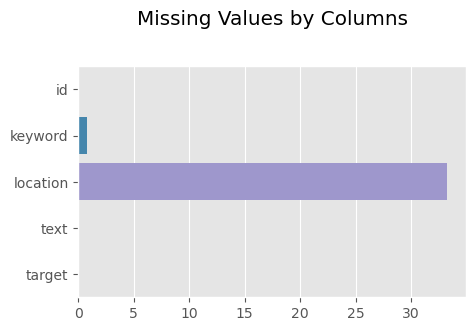

In [10]:
# Get the percentage of missing values
output = df_train.isnull().sum() * 100  / len(df_train) 
# type(output) : Pandas Series

# plot them
plt.figure(figsize=[5,3])
sns.barplot(y=list(output.index), x=list(output))
plt.title('Missing Values by Columns')
plt.show()

Keyword and location has missing values. Location has 33% data missing. This missing data could be tackled by detecting location in tweets and filling them up. I will not be doing this since I will be using tf-idf on the tweet text joined with location. Therefore, this step is not required for modelling though could be useful for EDA.  

In [11]:
df_train[~df_train['location'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


Evident that the location information is not consistant. It is also possible to extract location information from text as in id 50.

In [12]:
df_train[df_train['id'] == 48]['text']

31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
Name: text, dtype: object

## Column Names - STATIC

I prefer standardizing column names:

In [13]:
KEYWORD = 'keyword'
ID = 'id'
LOCATION = 'location'
TEXT = 'text'
TARGET = 'target'
TEXT_TOKENIZED = 'Text Tokenized'
SENTIMENT = 'Sentiment Score'
SENTIMENT_ROUND = 'Sentiment Score (rounded off)'
WORDS_PER_TWEET = 'Words Per Tweet'
CHAR_PER_TWEET = 'Characters Per Tweet'
LOCATIONS = 'Locations'
ALL_TEXT = 'all_text'
ALL_TEXT_JOINED = 'all_text_joined'
NUM_IN_TWEETS = 'Number in Tweet'
PUNCTUATION_COUNT = 'Punctuation Count Per Tweet'
IDENTIFIABLE_LOCATION = 'Identifiable Location'
IN_BOW = 'Present In BOW'

## Keyword Analysis

1. Which keywords have occurred the most?
2. Which keywords have a higher percentage of tweets about real disasters?

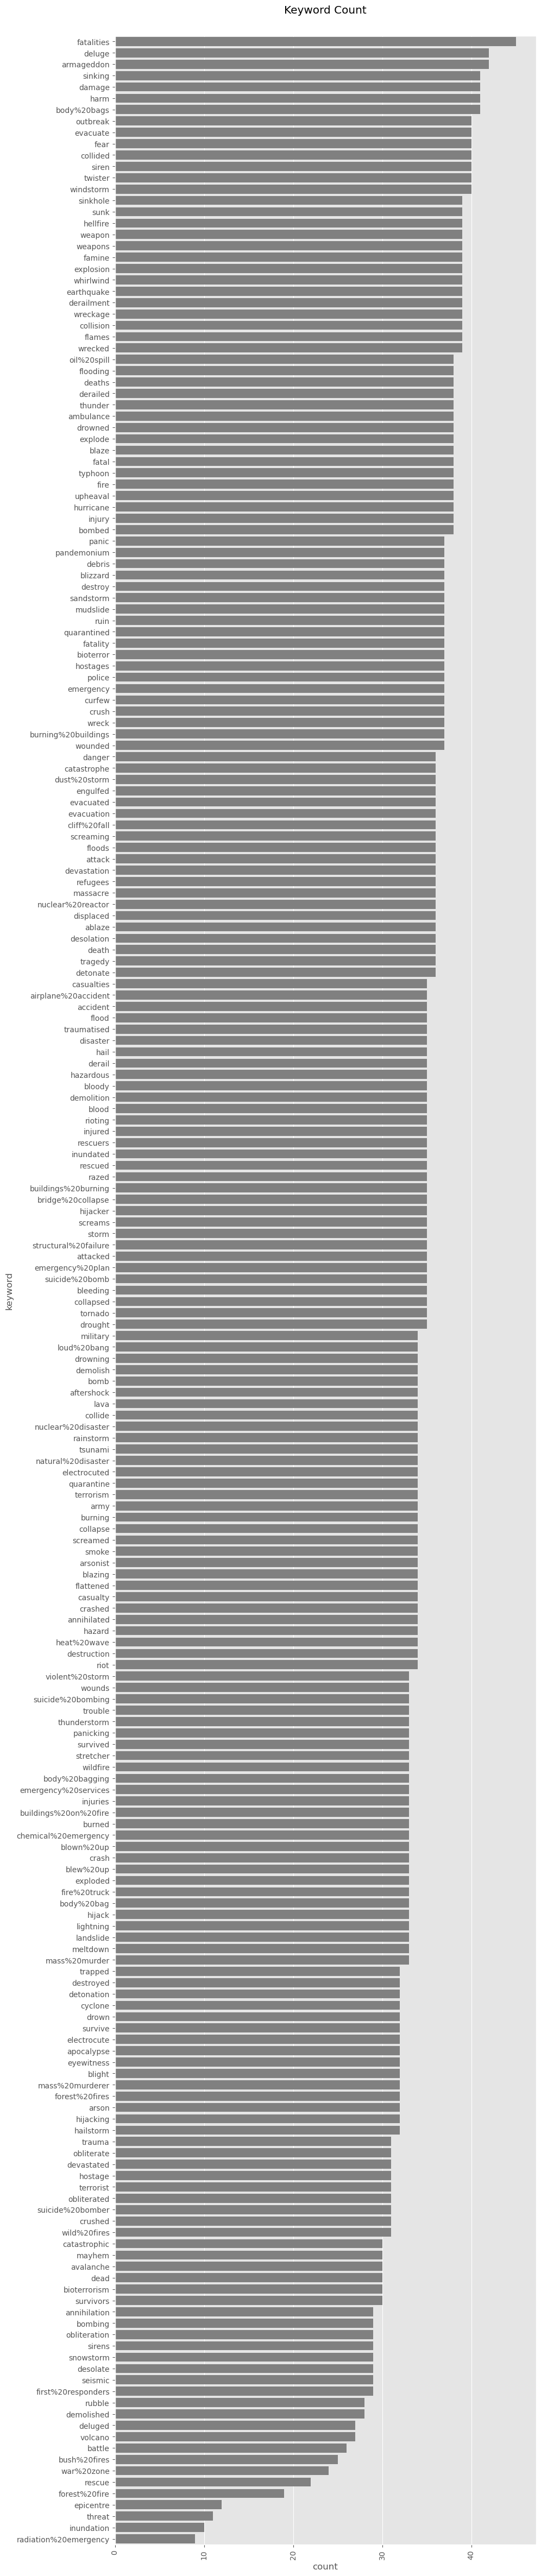

In [14]:
plt.figure(figsize=[10, 60])
sns.countplot(y=KEYWORD,
              data=df_train,
              palette=['grey'],
              order=df_train[KEYWORD].value_counts().index)
plt.xticks(rotation=90)
plt.title("Keyword Count")
plt.show()

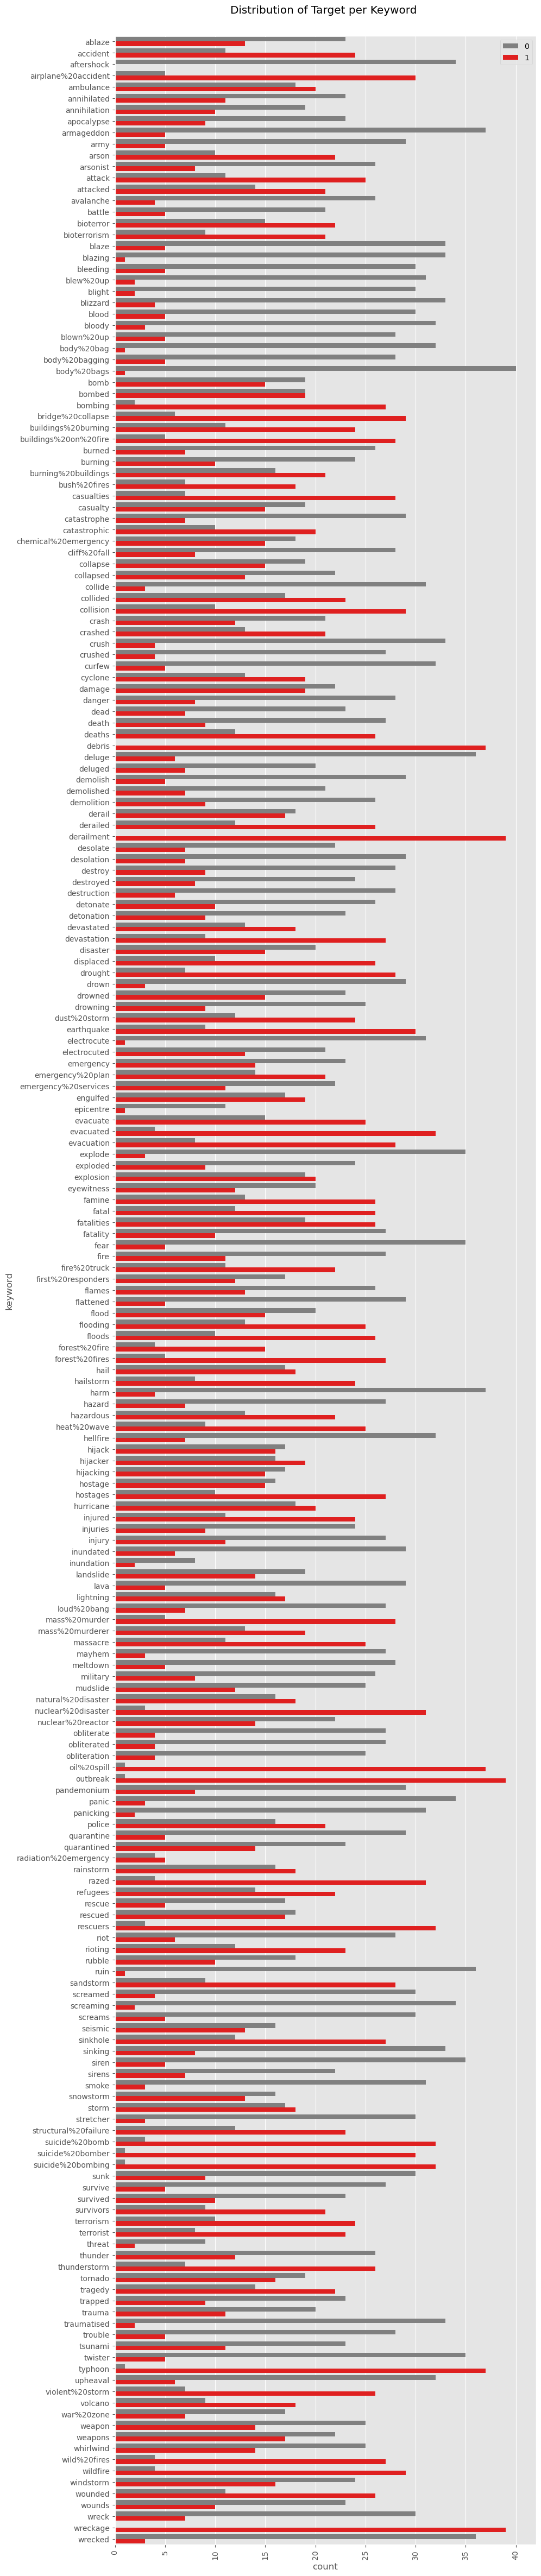

In [15]:
plt.figure(figsize=[10, 60])
sns.countplot(y=KEYWORD, hue=TARGET, data=df_train, palette=['grey', 'red'])
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title("Distribution of Target per Keyword ")
plt.show()

Blank spaces indicated by %20. Will require to clean this.

From this chart, it is seen that 'derailment', 'debris' and 'wreckage' are all about real disaster tweets. 

Body20%bags contains the higest difference between real and non-real disaster tweets where the number of non-real disaster tweets is high. It is actually the highest.

In [16]:
df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['@FoxNews @JenGriffinFNC When you call to report dangerous activity tell em to have body bags on arrival.'],
      dtype=object)

In [17]:
# Get keyword counts for tweets about real disasters
real_disaster_keywords = df_train[df_train['target'] == 1].groupby(['keyword', 'target']).count()['id'].reset_index()
real_disaster_keywords.head()

,keyword,target,id
0,ablaze,1,13
1,accident,1,24
2,airplane%20accident,1,30
3,ambulance,1,20
4,annihilated,1,11


In [18]:
# Get keyword counts for tweets not about real disasters
unreal_disaster_keywords = df_train[df_train['target'] == 0].groupby(['keyword', 'target']).count()['id'].reset_index()
unreal_disaster_keywords.head()

,keyword,target,id
0,ablaze,0,23
1,accident,0,11
2,aftershock,0,34
3,airplane%20accident,0,5
4,ambulance,0,18


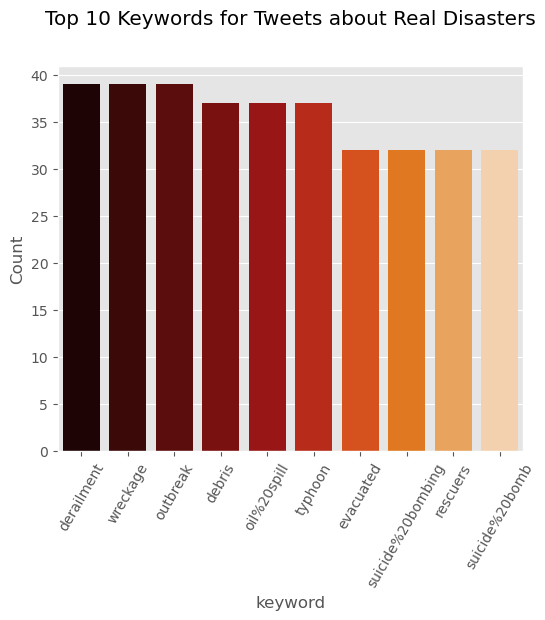

In [19]:
plt.figure(figsize=[6, 5])
sns.barplot(x=KEYWORD, y=ID, data=real_disaster_keywords.sort_values('id', ascending=False)[:10], palette='gist_heat')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.title('Top 10 Keywords for Tweets about Real Disasters')
plt.show()

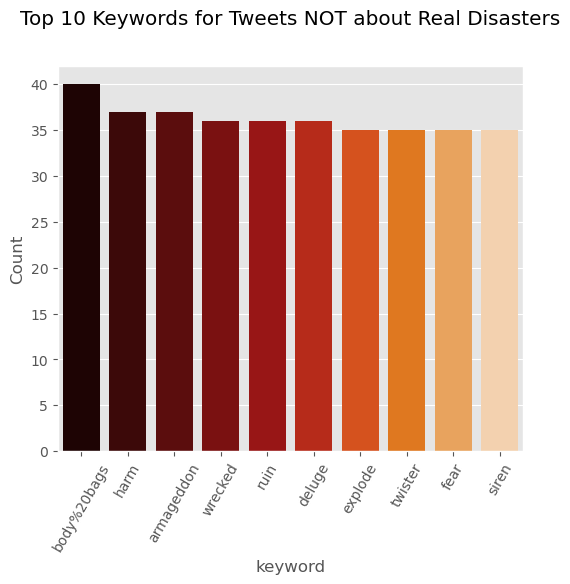

In [20]:
plt.figure(figsize=[6, 5])
sns.barplot(x=KEYWORD, y=ID, data=unreal_disaster_keywords.sort_values('id', ascending=False)[:10], palette='gist_heat')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.title('Top 10 Keywords for Tweets NOT about Real Disasters')
plt.show()

In [21]:
# Merge the counts and get calculate the probabilities that 
# if a particular keyword appears in a tweet, what is the probability that it is about a real disaster.

merged_counts_keywords = pd.merge(
    left=real_disaster_keywords,
    right=unreal_disaster_keywords,
    left_on=KEYWORD,
    right_on=KEYWORD,
    how='outer').drop(columns=['target_x', 'target_y']).fillna(0)

merged_counts_keywords['prob_real_disasters'] = (
    merged_counts_keywords['id_x'] -
    merged_counts_keywords['id_y']) / merged_counts_keywords['id_x']

top_prob_real_disaster_keywords = merged_counts_keywords.sort_values(
    'prob_real_disasters', ascending=False)[:10]
top_prob_real_disaster_keywords

,keyword,id_x,id_y,prob_real_disasters
69,derailment,39.0,0.0,1.000000
61,debris,37.0,0.0,1.000000
218,wreckage,39.0,0.0,1.000000
152,outbreak,39.0,1.0,0.974359
204,typhoon,37.0,1.0,0.972973
151,oil%20spill,37.0,1.0,0.972973
186,suicide%20bombing,32.0,1.0,0.968750
185,suicide%20bomber,30.0,1.0,0.966667
31,bombing,27.0,2.0,0.925926
165,rescuers,32.0,3.0,0.906250


## Target Analysis

**Imbalanced data** is a problem with classification tasks where the classes are not represented equally.Is the dataset balanced? 

In [22]:
df_train.target.value_counts() / len(df_train)

0    0.57034
1    0.42966
Name: target, dtype: float64

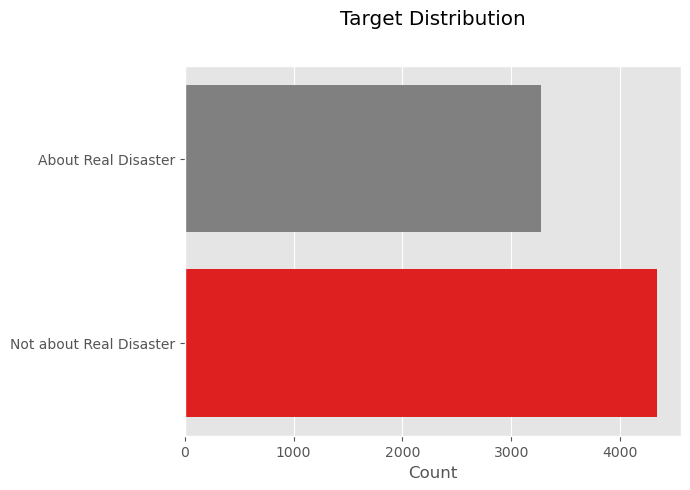

In [23]:
sns.countplot(y=TARGET,
              data=df_train[TARGET].replace({
                  0: 'Not about Real Disaster',
                  1: 'About Real Disaster'
              }).reset_index(),
              palette=['grey', 'red'])
plt.title('Target Distribution')
plt.ylabel(None)
plt.xlabel('Count')
plt.show()

This dataset is slightly imbalanced which should not be a problem for us. The disprity is of ~1000 datapoints where the number of non-disastrous tweets are higher.

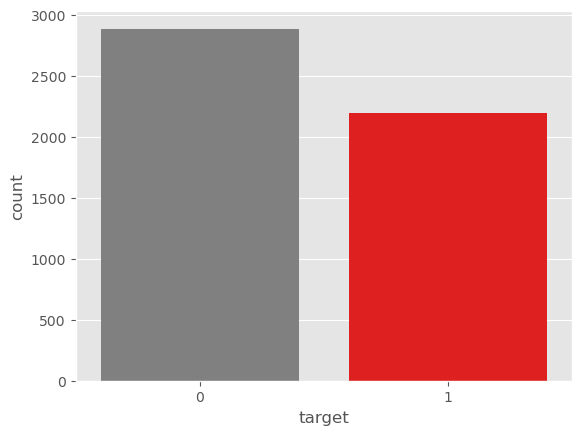

In [24]:
sns.countplot(x=TARGET, data=df_train[~df_train[LOCATION].isna()], palette=['grey', 'red'])
plt.show()

For the tweets whose location is NOT missing, the data imabalance is true in this case as well. Therefore, dropping the location null data will not help balancing the data.

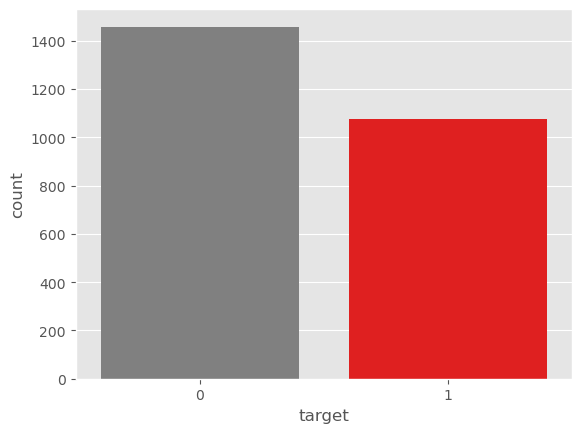

In [25]:
sns.countplot(x=TARGET, data=df_train[df_train[LOCATION].isna()], palette=['grey', 'red'])
plt.show()

For the tweets whose location is missing, the data imabalance is true in this case as well.

## Top 20 locations

Some locations are more prone to real disasters and it is highly likely that tweets from those locations will be about real disasters.

Objectives:

1. Nature of location data
2. Most frequently occurring locations

In [26]:
df_train[df_train[TARGET] == 1].groupby(LOCATION)[TARGET].count().reset_index()

,location,target
0,,1
1,News,1
2,"616 Û¢ Kentwood , MI",1
3,? ??????? ? ( ?? å¡ ? ? ? å¡),1
4,Alberta,1
...,...,...
1508,"ÌÏT: 40.562796,-75.488849",1
1509,"ÌÏT: 41.252426,-96.072013",1
1510,"ÌÏT: 6.4682,3.18287",1
1511,"ÌÏT: 6.488400524109015,3.352798039832285",1


There are some 
* gibberish locations
* latitudes and longitudes
* english words in location

In [27]:
df_train[df_train[TARGET] == 1].groupby(
    LOCATION)[TARGET].count().reset_index().sort_values(by=TARGET)

,location,target
0,,1
979,Porthcawl,1
978,"Portage, IN / Worldwide",1
977,Port Williams NS,1
976,"Port Orange, FL",1
...,...,...
787,Mumbai,19
576,India,20
857,Nigeria,22
1258,United States,27


There are -
* city
* city, state
* city, country
* country abbreviation
* country name
* city, country / worldwide

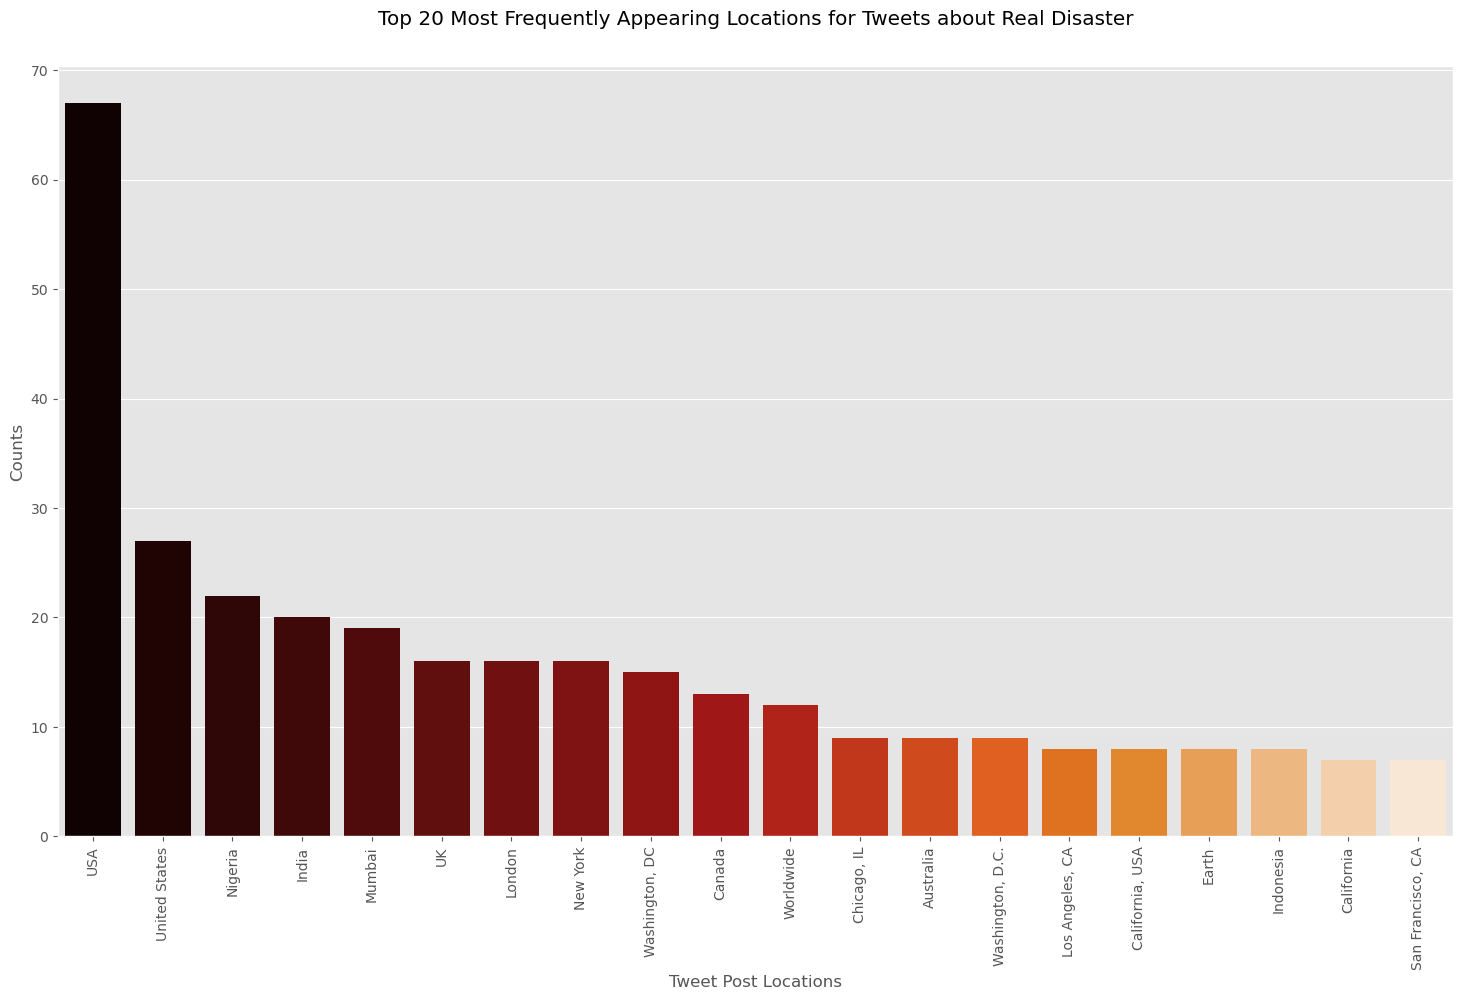

In [28]:
plt.figure(figsize=[18, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET,
                                                       ascending=False)[:20],
            palette='gist_heat'
           )
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequently Appearing Locations for Tweets about Real Disaster')
plt.xlabel('Tweet Post Locations')
plt.ylabel('Counts')
plt.show()

There is an overlap of countries, cities and there are also co-ordinate information plus some gibberish data.

## Text Data Check

Here is have random tweet text checks  to see what is in there

In [29]:
df_train[TEXT][8], df_train[TARGET][8]

("There's an emergency evacuation happening now in the building across the street",
 1)

In [30]:
df_train[TEXT][20], df_train[TARGET][20]

('this is ridiculous....', 0)

In [31]:
df_train[TEXT][1000] , df_train[TARGET][1000]

('#OVOFest Drake straight body bagging Meek on that OVO stage. #ZIPHIMUP!', 0)

In [32]:
df_train[TEXT][2000] , df_train[TARGET][2000]

('@BradleyBrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough',
 0)

**Notes:**

To remove:
1. urls from the texts, 
2. html tags
3. mentions using @.
4. %20 from keywords

Will retain hashtags since importance information lies in hasgtags but will remove the # in them.

# Basic Cleaning

A regular expression or regex is a set of characters, or a pattern, which is used to find sub strings in a given string like getting urls, numbers, extracting all hashtags and mentions from a tweet from a large unstructured corpus.

In python, re.sub does the job of substituting a detected pattern with a substitute in an input string. The syntax is as follows:

```re.sub(pattern, replacement, input)```

Other options are - findall, fullmatch, split

## Cleaning Tests

In [33]:
test_string = 'I am at https://www.nabanita.org www.nabanita.org okay'
url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
test_op = re.sub(url_pattern, '', test_string)
test_op

'I am at   okay'

In [34]:
test_string = 'I am at <p>www.nabanita.org &nbsp;</p>'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org '

In [35]:
test_string = 'I am at @nabanita #python testing 123'
html_entities = r'@([a-z0-9]+)|#'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at  python testing 123'

A tweet might tag news channels as well which contains the word 'news'. If they are twitter handles, then the information will be lost. Hence adding this function to add the keyword news to the tweet if the word is present in the tweet text.

## Text Preprocessing Functions

In [36]:
def remove_urls(text):
    ''' This method takes in text to remove urls and website links, if any'''
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    return text


def remove_html_entities(text):
    ''' This method removes html tags'''
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    text = re.sub(html_entities, '', text)
    return text


def convert_lower_case(text):
    return text.lower()


def detect_news(text):
    '''Appends news to the end of the tweet if news appears anywhere in the tweet. 
    This is to avoid missing out on the keyword 'news' if it occured in a mention, for ex: @SomeNewsChannel'''
    if 'news' in text:
        text = text + ' news'
    return text


def remove_social_media_tags(text):
    ''' This method removes @ and # tags'''
    tag_pattern = r'@([a-z0-9]+)|#'
    text = re.sub(tag_pattern, '', text)
    return text


# Count it before I remove them altogether
def count_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?', text)
    return len(getpunctuation)


def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x) ## Add nltk.word_tokenizer
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [
        wnl.lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in STOPWORDS and each_word.strip() != ''
    ]
    return " ".join(word_list)

In [41]:
df_train[TEXT] = df_train[TEXT].apply(remove_urls)
df_train[TEXT] = df_train[TEXT].apply(remove_html_entities)
df_train[TEXT] = df_train[TEXT].apply(convert_lower_case)
df_train[TEXT] = df_train[TEXT].apply(detect_news)
df_train[TEXT] = df_train[TEXT].apply(remove_social_media_tags)
df_train[PUNCTUATION_COUNT] = df_train[TEXT].apply(count_punctuations)
df_train[TEXT] = df_train[TEXT].apply(preprocess_text)

In [42]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0


In [43]:
# Test

# Expected to remove @FoxNews but have ' news' in the tweet text

df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['call report dangerous activity tell body bag arrival news news'],
      dtype=object)

## Punctuation Analysis

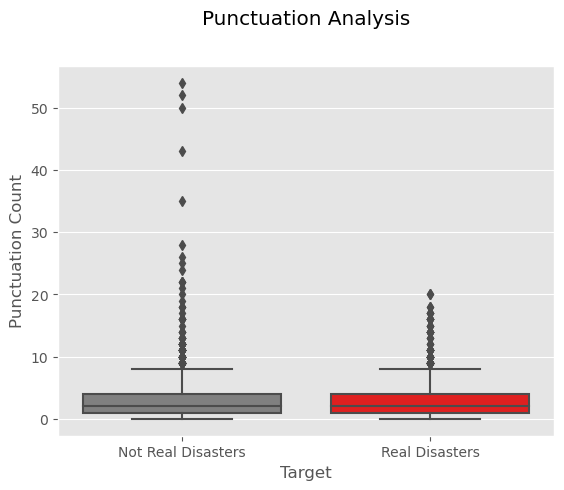

In [44]:
sns.boxplot(x=TARGET,
            y=PUNCTUATION_COUNT,
            data=df_train,
            palette=['grey', 'red'])
plt.title('Punctuation Analysis')
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
plt.xlabel('Target')
plt.ylabel('Punctuation Count')
plt.show()

## Keyword Check

In [45]:
def clean_keyword(text):
    if text is not np.nan and text:
        text = text.replace('%20', ' ')
    return text

In [46]:
df_train[KEYWORD] = df_train[KEYWORD].apply(clean_keyword)

In [47]:
df_train[KEYWORD].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desol

# Mention of Numbers in Tweets

Information on real disasters usually have a casualty count in numbers. Therefore, it is worth analyzing if numbers are present in the tweets.

In [48]:
def get_numbers_in_tweet(text):
    list_numbers = re.findall(r'\d+', text)
    if list_numbers:
        return 1
    return 0

In [49]:
df_train[NUM_IN_TWEETS] = df_train[TEXT].apply(get_numbers_in_tweet)

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           7613 non-null   int64 
 1   keyword                      7552 non-null   object
 2   location                     5080 non-null   object
 3   text                         7613 non-null   object
 4   target                       7613 non-null   int64 
 5   Punctuation Count Per Tweet  7613 non-null   int64 
 6   Number in Tweet              7613 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 416.5+ KB


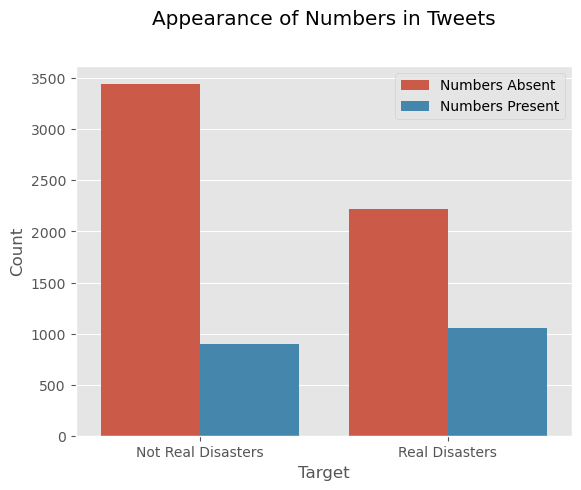

In [51]:
sns.countplot(x=TARGET, hue=NUM_IN_TWEETS, data=df_train)
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks = [0, 1])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Appearance of Numbers in Tweets')
plt.legend(labels=['Numbers Absent', 'Numbers Present'])
plt.show()

About 50% of the tweets about real disatsers have numbers present.

# Sentiment Analysis

The sentiment about real disasters would be generally negative. What is the assessed sentiment for these tweets?

In [57]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [70]:
# python -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [71]:
df_train[SENTIMENT] = df_train[TEXT].apply(lambda x: nlp(x)._.polarity)

In [72]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Text Tokenized,Words Per Tweet,Characters Per Tweet,Sentiment Score
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,0.0
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,"[forest, fire, near, la, ronge, sask, canada]",7,37,0.1
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,"[resident, asked, shelter, place, notified, of...",11,85,-0.1
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,"[13000, people, receive, wildfire, evacuation,...",7,57,0.0
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,0.0


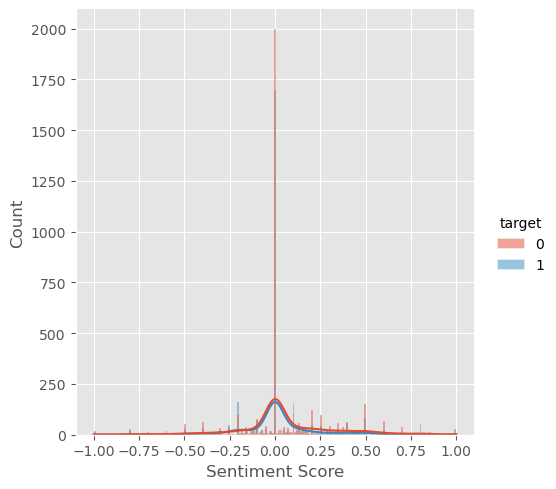

In [73]:
sns.displot(x=SENTIMENT, hue=TARGET, data=df_train, kde=True)
plt.show()

The sentiment is a continuous number. How does it look like when we binarize it?

In [74]:
def sentiment_to_binary(x):
    if x > 0:
        return 1
    else:
        return 0

In [75]:
df_train[SENTIMENT_ROUND] = df_train[SENTIMENT].apply(sentiment_to_binary)
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Text Tokenized,Words Per Tweet,Characters Per Tweet,Sentiment Score,Sentiment Score (rounded off)
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,0.0,0
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,"[forest, fire, near, la, ronge, sask, canada]",7,37,0.1,1
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,"[resident, asked, shelter, place, notified, of...",11,85,-0.1,0
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,"[13000, people, receive, wildfire, evacuation,...",7,57,0.0,0
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,0.0,0


In [76]:
df_train[SENTIMENT_ROUND].value_counts()

0    5268
1    2345
Name: Sentiment Score (rounded off), dtype: int64

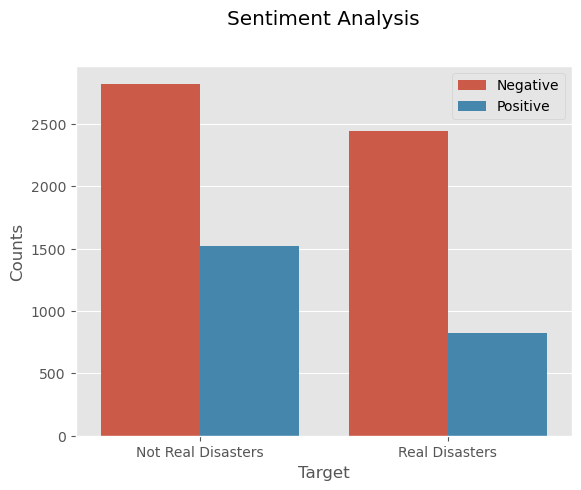

In [77]:
sns.countplot(x=TARGET, hue=SENTIMENT_ROUND, data=df_train)
plt.title('Sentiment Analysis')
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
plt.xlabel('Target')
plt.ylabel('Counts')
# plt.ylabel('Punctuation Count')
plt.legend(labels=['Negative', 'Positive'])
plt.show()

The percentage of negative sentiment is more in tweets about real disasters than in tweets not about real disasters.

# Tweet Length Analysis

Are the tweets about real disasters shorter or longer in nature?

In [78]:
df_train[TEXT_TOKENIZED] = df_train[TEXT].apply(word_tokenize)

In [79]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Text Tokenized,Words Per Tweet,Characters Per Tweet,Sentiment Score,Sentiment Score (rounded off)
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,0.0,0
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,"[forest, fire, near, la, ronge, sask, canada]",7,37,0.1,1
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,"[resident, asked, shelter, place, notified, of...",11,85,-0.1,0
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,"[13000, people, receive, wildfire, evacuation,...",7,57,0.0,0
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,0.0,0


In [80]:
df_train[WORDS_PER_TWEET] = df_train[TEXT_TOKENIZED].apply(len)
df_train[CHAR_PER_TWEET] = df_train[TEXT].apply(len)

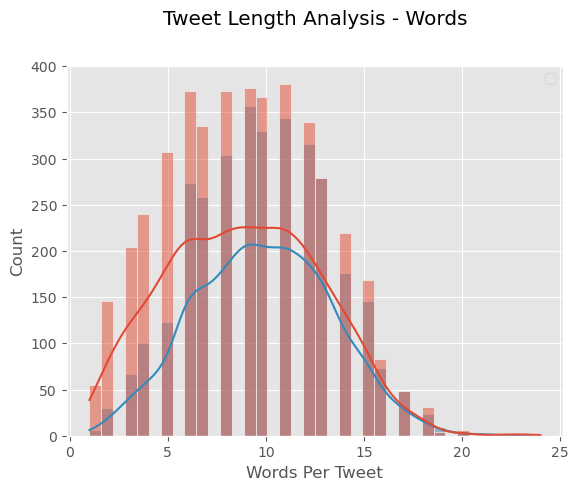

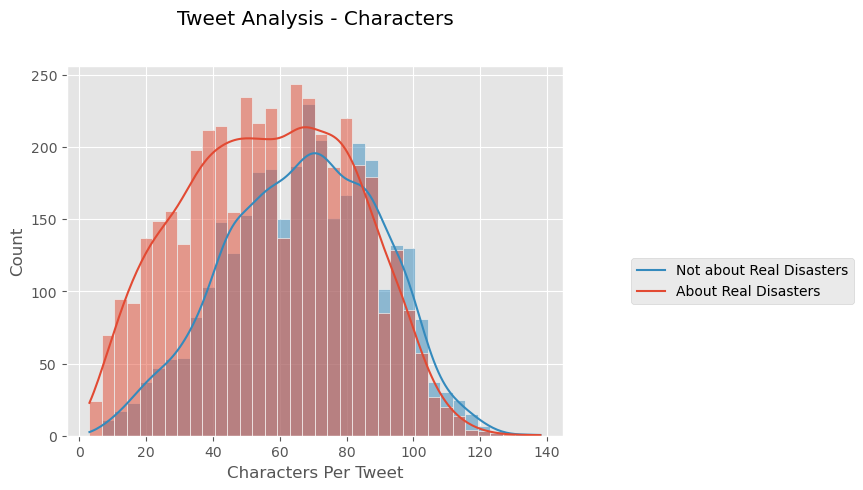

In [81]:
sns.histplot(x=WORDS_PER_TWEET, hue=TARGET, data=df_train, kde=True)
plt.title('Tweet Length Analysis - Words')
plt.legend([])
plt.show()
sns.histplot(x=CHAR_PER_TWEET, hue=TARGET, data=df_train, kde=True)
plt.title('Tweet Analysis - Characters')
plt.legend(labels=['Not about Real Disasters', 'About Real Disasters'], loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

# Tweet Text Analysis using WordCloud

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. 

In [82]:
real_disaster_tweets = ' '. join(list(df_train[df_train[TARGET] == 1][TEXT]))

In [83]:
non_real_disaster_tweets = ' '. join(list(df_train[df_train[TARGET] == 0][TEXT]))

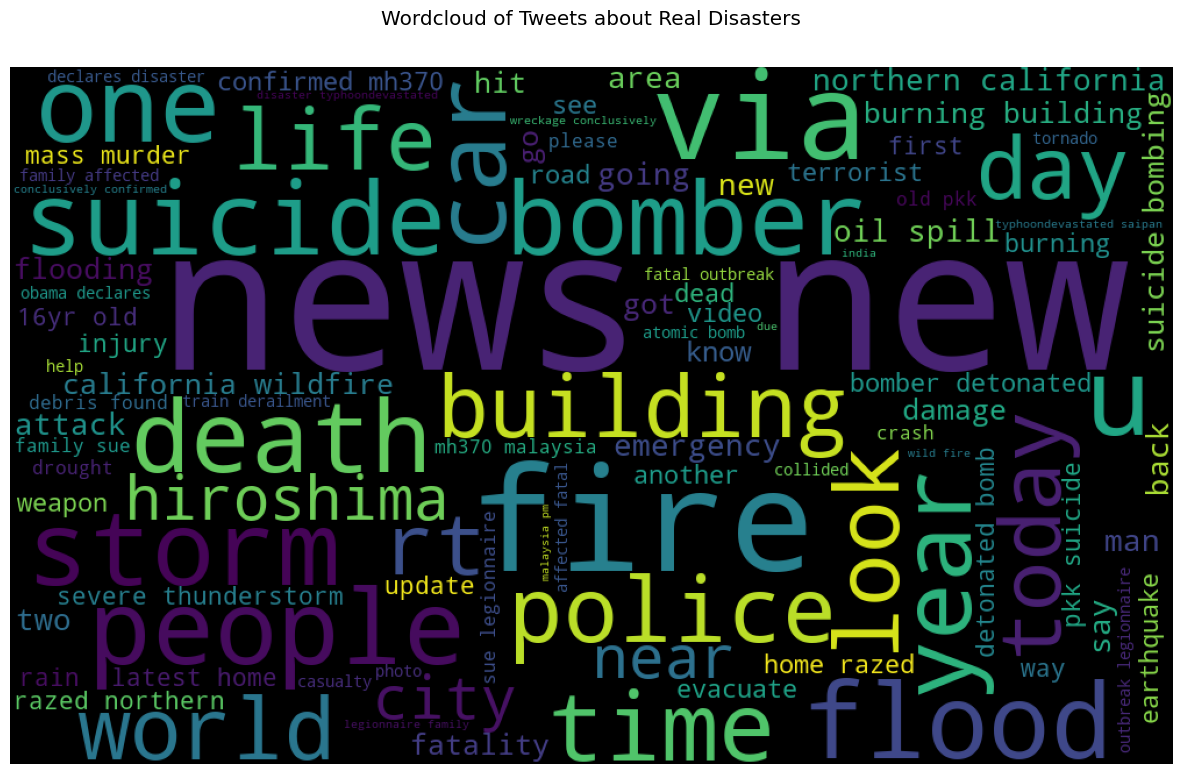

In [84]:
wc = WordCloud(background_color="black", 
               max_words=100, 
               width=1000, 
               height=600, 
               random_state=1).generate(real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets about Real Disasters")
plt.show()

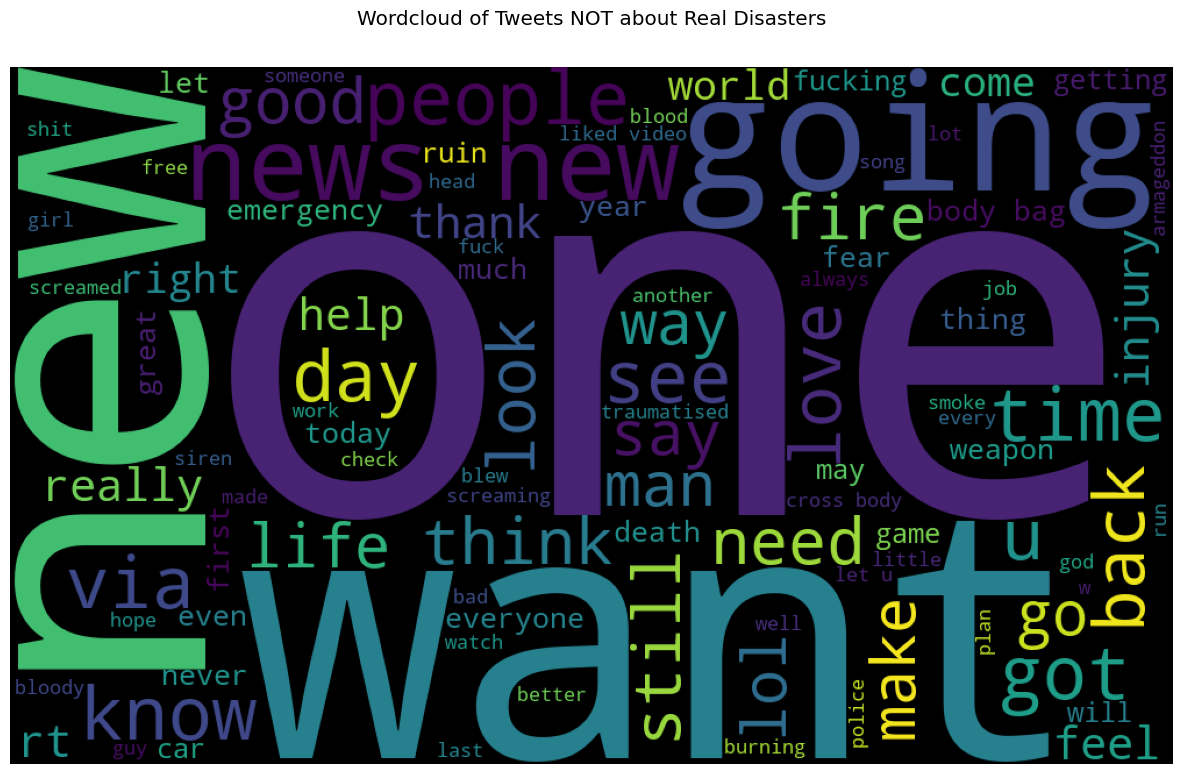

In [85]:
wc = WordCloud(background_color="black", 
               max_words=100, 
               width=1000, 
               height=600,
               font_step=1,
               random_state=1).generate(non_real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets NOT about Real Disasters")
plt.show()

Emojis are present in the text, as evident on the wordcloud. Therefore, they need to be either detected or removed. I will not be addressing emoji detection in this project.

# Location Analysis - SKIP

Do tweets about real disasters have more standard locations which are detectable by NER?

In [86]:
def check_location(x):
    ''' This method checks if the tweet location has any actual location 
    and saves them as as space-separated value if more than one.
    If no location is found, then save blank'''
    spacy_loc = nlp(x)
    num_loc_in_tweet = len([ent.label_ for ent in spacy_loc.ents if ent.label_ == 'GPE'])
    if num_loc_in_tweet:
        locs_in_tweet = [ent.text for ent in spacy_loc.ents if ent.label_ == 'GPE']
    else:
        return [], 0
    return locs_in_tweet, 1

df_train[LOCATION].fillna('', inplace=True)
df_train[LOCATIONS], df_train[IDENTIFIABLE_LOCATION] = zip(*df_train[LOCATION].apply(check_location))

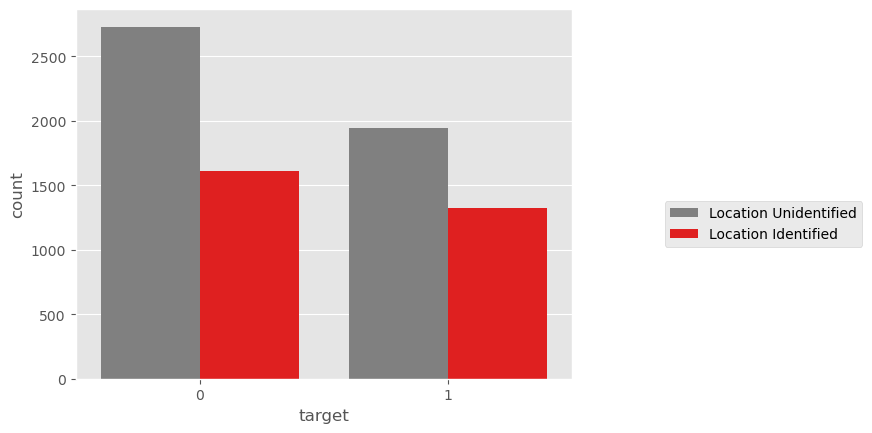

In [87]:
sns.countplot(x=TARGET, hue=IDENTIFIABLE_LOCATION, data=df_train, palette=['grey', 'red'])
plt.legend(labels=['Location Unidentified', 'Location Identified'], loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

Tweets about real disasters have a slightly higher percentage of location identified by the named-entity identifier.

# Final Text Data Preparation

In [88]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Text Tokenized,Words Per Tweet,Characters Per Tweet,Sentiment Score,Sentiment Score (rounded off),Locations,Identifiable Location
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,0.0,0,[],0
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,"[forest, fire, near, la, ronge, sask, canada]",7,37,0.1,1,[],0
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,"[resident, asked, shelter, place, notified, of...",11,85,-0.1,0,[],0
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,"[13000, people, receive, wildfire, evacuation,...",7,57,0.0,0,[],0
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,0.0,0,[],0


In [89]:
df_train[ALL_TEXT] = df_train[TEXT_TOKENIZED] + df_train[LOCATIONS]
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Text Tokenized,Words Per Tweet,Characters Per Tweet,Sentiment Score,Sentiment Score (rounded off),Locations,Identifiable Location,all_text
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,0.0,0,[],0,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,"[forest, fire, near, la, ronge, sask, canada]",7,37,0.1,1,[],0,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,"[resident, asked, shelter, place, notified, of...",11,85,-0.1,0,[],0,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,"[13000, people, receive, wildfire, evacuation,...",7,57,0.0,0,[],0,"[13000, people, receive, wildfire, evacuation,..."
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,0.0,0,[],0,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [90]:
target = df_train[TARGET].values

In [91]:
df_train[ALL_TEXT_JOINED] = df_train[ALL_TEXT].apply(lambda x: " ".join(x))

The training data is ready now. Next step, prepping the test data.

# Building a Data Modeling Pipeline

**Text Vectorizing** is a common method which converts a sequenceo of text to a sequence of numbers. The sequence of numbers could represent a token or a sentence, depending on your use-case.

Count Vectors and Tf-idf are the most common methods of vectorizing texts.

**Training a ML model** is the next step where the vectorized forms of texts are fed to a model, like logistic regression in this case. After model training, its performance is evaluated.

**Classification Evaluation Metrics**

1. Accuracy
2. Precision
3. Recall
4. F1-score

## Helper Functions

In [92]:
def print_classification_metrics(y_train, train_pred, y_test, test_pred):
    print('Training Accuracy: ', accuracy_score(y_train, train_pred))
    print('Training f1-score: ', f1_score(y_train, train_pred))
    print('Accuracy: ', accuracy_score(y_test, test_pred))
    print('Precision: ', precision_score(y_test, test_pred))
    print('Recall: ', recall_score(y_test, test_pred))
    print('f1-score: ', f1_score(y_test, test_pred))
    
def predict_challenge_test_data(model, test_data, filename):
    submission_predictions = model.predict(test_data)
    df_submission = pd.read_csv('data/sample_submission.csv')
    df_submission[TARGET] = submission_predictions
    df_submission.to_csv(filename, index=False)

## Count Vectorizer

In [93]:
cols_to_train = [ALL_TEXT_JOINED]

tt = TweetTokenizer()

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

ct = ColumnTransformer([('count_vec',
                         CountVectorizer(tokenizer=tt.tokenize,
                                         ngram_range=(1, 2)),
                                         ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)

In [94]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
test_prediction = log_reg.predict(X_test_sparse)
training_prediction = log_reg.predict(X_train_sparse)

In [95]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction) # Replace this with scikitlearn impl

Training Accuracy:  0.987192118226601
Training f1-score:  0.9850057670126874
Accuracy:  0.8063033486539725
Precision:  0.8241758241758241
Recall:  0.6933744221879815
f1-score:  0.7531380753138075


## TF-IDF Vectorizer

In [96]:
cols_to_train = [ALL_TEXT_JOINED]

tt = TweetTokenizer()

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

ct = ColumnTransformer([('tfidf',
                         TfidfVectorizer(tokenizer=tt.tokenize,
                                         ngram_range=(1, 2),
                                         smooth_idf=True), ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)

In [97]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
test_prediction = log_reg.predict(X_test_sparse)
training_prediction = log_reg.predict(X_train_sparse)

In [98]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction)

Training Accuracy:  0.9078817733990148
Training f1-score:  0.8835374714552626
Accuracy:  0.7997373604727511
Precision:  0.8208955223880597
Recall:  0.6779661016949152
f1-score:  0.7426160337552744


## Experimenting with multiple classifiers - SKIP

In [99]:
def test_multiple_model(model_list):
    for model in model_list:
        cols_to_train = [ALL_TEXT_JOINED]

        tt = TweetTokenizer()

        X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                            df_train[TARGET].values,
                                                            test_size=0.2,
                                                            random_state=42)

        ct = ColumnTransformer([('tfidf',
                                 TfidfVectorizer(tokenizer=tt.tokenize,
                                                 ngram_range=(1, 2),
                                                 smooth_idf=True), ALL_TEXT_JOINED)],
                               remainder='passthrough')

        ct.fit(X_train)
        X_train_sparse = ct.transform(X_train)
        X_test_sparse = ct.transform(X_test)
        model.fit(X_train_sparse, y_train)
        test_prediction = model.predict(X_test_sparse)
        training_prediction = model.predict(X_train_sparse)
        print("Model Name: ", type(model).__name__)
        print_classification_metrics(y_train, training_prediction, y_test, test_prediction)
        print("-------------------------------------")

In [100]:
list_init_models = [LogisticRegression(),
                    MultinomialNB(),
                    DecisionTreeClassifier()]

In [101]:
test_multiple_model(list_init_models)

Model Name:  LogisticRegression
Training Accuracy:  0.9078817733990148
Training f1-score:  0.8835374714552626
Accuracy:  0.7997373604727511
Precision:  0.8208955223880597
Recall:  0.6779661016949152
f1-score:  0.7426160337552744
-------------------------------------
Model Name:  MultinomialNB
Training Accuracy:  0.9395730706075534
Training f1-score:  0.9259855189058729
Accuracy:  0.799080761654629
Precision:  0.8464646464646465
Recall:  0.6456086286594761
f1-score:  0.7325174825174826
-------------------------------------
Model Name:  DecisionTreeClassifier
Training Accuracy:  0.9924466338259442
Training f1-score:  0.991180981595092
Accuracy:  0.7261982928430729
Precision:  0.6762917933130699
Recall:  0.6856702619414484
f1-score:  0.6809487375669472
-------------------------------------


## Future Work

1. Experiment with adding the features to the pipeline
2. Experiment with emoji detection in the texts
3. Tune the model for better performance
4. Use word2vec on the texts and assess performance

Thanks for visiting!